<!-- # This code uses the decoder to graph the pre-lesion phrase duration against the post-lesion phrase duration for bird (color-coded), with a point for each syllable type.

## Adjust lines 72 and 73 to be the path to the decoder output .json file and the creation data/parameters .json file that contains the treatment date.
### You will (eventually) need to have a folder of all of the Area X lesioned birds' decoders .csv in it. -->

<!-- ### Step 0: Make a folder that has the .csv files from all of the Area X birds. -->

# This code takes in one bird's TweetyBERT decoder .json file, then graphs their pre vs. post phrase durations mean, median, and variances. It generates a .csv file so you can combine data for graphing for different datasets (e.g. sham lesion, visible Area X).

<!-- # Figure out the basic task first: -->

<!-- For now, load ONE .csv file, organize it into a dataframe.  -->

In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime

class DecoderDataProcessor:
    def __init__(self, json_file_path, json_date_file_path):
        self.json_file_path = json_file_path
        self.json_date_file_path = json_date_file_path
        self.decoder_dataframe = self.load_data()
        self.subdirectory_dates = self.load_subdirectory_dates()

    def load_data(self):
        print(f"Reading JSON file: {self.json_file_path}")
        with open(self.json_file_path, 'r') as f:
            decoder_data = json.load(f)['results']
        return pd.DataFrame(decoder_data)

    def load_subdirectory_dates(self):
        with open(self.json_date_file_path, 'r') as f:
            json_data = json.load(f)
            subdirectory_dates = {subdir: datetime.strptime(data['subdirectory_creation_date'], "%Y-%m-%d").date() for subdir, data in json_data['subdirectories'].items()}
        return subdirectory_dates

    def parse_json_safe(self, s):
        if isinstance(s, dict):
            return s
        if pd.isna(s):
            return {}
        s = s.strip().strip("''")
        s = s.replace("'", '"')
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return {}

    def organize_data(self):
        self.decoder_dataframe['syllable_onsets_offsets_ms'] = self.decoder_dataframe['syllable_onsets_offsets_ms'].apply(self.parse_json_safe)
        self.decoder_dataframe['syllable_onsets_offsets_timebins'] = self.decoder_dataframe['syllable_onsets_offsets_timebins'].apply(self.parse_json_safe)
        
        self.decoder_dataframe = self.decoder_dataframe[self.decoder_dataframe['song_present'] == True].reset_index(drop=True)
        for i, row in self.decoder_dataframe.iterrows():
            file_name = row['file_name']
            animal_id, date_str, hour, minute, second = self.extract_date_time(file_name)
            self.decoder_dataframe.at[i, 'Animal ID'] = animal_id
            self.decoder_dataframe.at[i, 'Date'] = self.apply_year_correction(date_str)
            self.decoder_dataframe.at[i, 'Hour'] = hour
            self.decoder_dataframe.at[i, 'Minute'] = minute
            self.decoder_dataframe.at[i, 'Second'] = second
        self.decoder_dataframe['Date'] = pd.to_datetime(self.decoder_dataframe['Date'], format='%Y.%m.%d', errors='coerce')

    def extract_date_time(self, file_name):
        try:
            parts = file_name.split('_')
            return parts[0], f"{parts[2]}.{parts[3]}", parts[4], parts[5], parts[6].replace('.wav', '')
        except IndexError:
            return None, None, None, None, None

    def apply_year_correction(self, month_day):
        if month_day is None:
            return None
        try:
            month, day = month_day.split('.')
            for subdir, date in self.subdirectory_dates.items():
                if date.month == int(month) and date.day == int(day):
                    return date.strftime('%Y.%m.%d')
        except ValueError:
            return None
        return None

# Usage
json_file_path = '/Users/mirandahulsey-vincent/Desktop/RC7_USA5499_tweetybert_outputs/USA5499_decoded_database.json'
json_date_file_path = '/Users/mirandahulsey-vincent/Desktop/RC7_USA5499_tweetybert_outputs/USA5499_Comp2_treatment_and_recording_dates.json'
processor = DecoderDataProcessor(json_file_path, json_date_file_path)
processor.organize_data()
print(processor.decoder_dataframe.head(3))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reading JSON file: /Users/mirandahulsey-vincent/Desktop/RC7_USA5499_tweetybert_outputs/USA5499_decoded_database.json
                                  file_name        creation_date  \
0  USA5499_45679.38633704_1_22_10_43_53.wav  2025-01-22T10:44:26   
1  USA5499_45679.38665937_1_22_10_44_25.wav  2025-01-22T10:44:50   
2   USA5499_45679.40621870_1_22_11_17_1.wav  2025-01-22T11:17:44   

   song_present                         syllable_onsets_offsets_ms  \
0          True  {'13': [[0.0, 1821.4285

<!-- Find the treatment day and type. -->

In [2]:
import os
import json
# Load the JSON file and extract the treatment date
with open(json_date_file_path, 'r') as file:
    json_data = json.load(file)

#find the animal ID from the file name:
file_name = os.path.basename(json_date_file_path)
animal_id = file_name.split('_')[0]  # Assuming the ID is always the first part of the file name

# Extract and print the treatment date and type
treatment_date = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")

print(f"Animal ID: {animal_id}")
print(f"Treatment Date: {treatment_date}")
print(f"Treatment Type: {treatment_type}")

Animal ID: USA5499
Treatment Date: 2025-02-20
Treatment Type: Bilateral Area X excitotoxic lesions


<!-- Split up the data into pre-lesion and post-lesion data. -->

In [3]:
# Get data from one day
df = pd.DataFrame(processor.decoder_dataframe)
specific_date = pd.Timestamp('2024-03-19')

# Filter the DataFrame for rows where the Date column matches the specific date
filtered_df = df[df
['Date'] == specific_date]

# Select the syllable_onsets_offsets_ms column from the filtered DataFrame
syllable_onsets_offsets_ms_values = filtered_df['syllable_onsets_offsets_ms']
print(syllable_onsets_offsets_ms_values)

Series([], Name: syllable_onsets_offsets_ms, dtype: object)


<!-- Find all the unique syllable labels from TweetyBERT. -->

In [4]:
df = pd.DataFrame(processor.decoder_dataframe)

# Function to extract unique syllable labels from a DataFrame
def extract_unique_syllable_labels(df):
    unique_syllable_labels = set()
    for syllable_dict in df['syllable_onsets_offsets_ms']:
        if isinstance(syllable_dict, dict):
            unique_syllable_labels.update(syllable_dict.keys())
    return sorted(unique_syllable_labels)  # Return a sorted list of unique labels for easier viewing

# Extract and print unique syllable labels
unique_labels = extract_unique_syllable_labels(df)
print("Unique syllable labels:", unique_labels)


Unique syllable labels: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '7', '8', '9']


<!-- Balance the datsets by figuring out which has the smallest sample size, then take an equivalent number of song from the second half of the pre-lesion data (and all data from the post-lesion dataset?) -->

In [5]:
# Count rows before the treatment date
rows_before_treatment = df[df['Date'] < treatment_date].shape[0]
# Count rows after the treatment date
rows_after_treatment = df[df['Date'] > treatment_date].shape[0]
# Set song_sample_size to the smallest value between rows_before_treatment and rows_after_treatment
song_sample_size = min(rows_before_treatment, rows_after_treatment)

print("Song sample size:", song_sample_size)

# Filter the DataFrame for rows before the treatment date and sort by Date descending to get the latest data
pre_treatment = df[df['Date'] < treatment_date].sort_values(by='Date', ascending=False).head(song_sample_size)

# Filter the DataFrame for rows after the treatment date and sort by Date ascending to get the earliest data
post_treatment = df[df['Date'] > treatment_date].sort_values(by='Date', ascending=True).head(song_sample_size)

# Display the result
print("Pre-treatment data:", pre_treatment.head(3))
print("Post-treatment data:", post_treatment)


Song sample size: 263
Pre-treatment data:                                      file_name        creation_date  \
3139  USA5499_45707.51322874_2_19_14_15_22.wav  2025-02-19T14:17:16   
3042    USA5499_45707.29642887_2_19_8_14_2.wav  2025-02-19T08:14:32   
3044   USA5499_45707.29984866_2_19_8_19_44.wav  2025-02-19T08:20:20   

      song_present                         syllable_onsets_offsets_ms  \
3139          True                 {'15': [[0.0, 35.07936507936508]]}   
3042          True  {'9': [[0.0, 831.1111111111112], [955.23809523...   
3044          True  {'15': [[0.0, 18.88888888888889], [275.2380952...   

                       syllable_onsets_offsets_timebins Animal ID       Date  \
3139                                {'15': [[0.0, 13]]}   USA5499 2025-02-19   
3042  {'9': [[0.0, 308], [354.0, 417], [2319.0, 2334...   USA5499 2025-02-19   
3044  {'15': [[0.0, 7], [102.0, 188]], '19': [[7.0, ...   USA5499 2025-02-19   

     Hour Minute Second  
3139   14     15     22  
3042   

<!-- For one syllable type, find all the onset and offset values. I'll choose '26', since it shows up with more than one onset/offset interval, so I can make sure the code checks all of the intervals for durations. -->

<!-- Now, get it to iterate over all the unique syllable labels that you found from the unique_labels array: -->

In [6]:
import pandas as pd
import ast  # Import Abstract Syntax Trees to safely evaluate strings containing Python literals

# Function to calculate durations for a specified syllable type
def calculate_durations(df, syllable_type):
    durations = []
    for index, row in df.iterrows():
        syllable_data = ast.literal_eval(row['syllable_onsets_offsets_ms'])
        if syllable_type in syllable_data:
            for interval in syllable_data[syllable_type]:
                duration = interval[1] - interval[0]


In [7]:
import pandas as pd
import ast  # Import Abstract Syntax Trees to safely evaluate strings containing Python literals

# Function to calculate durations for each syllable type
def calculate_durations(df, syllable_labels):
    durations_dict = {label: [] for label in syllable_labels}  # Initialize a dictionary to store durations for each label
    for index, row in df.iterrows():
        syllable_data = row['syllable_onsets_offsets_ms']
        for label in syllable_labels:
            if label in syllable_data:
                for interval in syllable_data[label]:
                    duration = interval[1] - interval[0]  # Calculate duration
                    durations_dict[label].append(duration)  # Append duration to the corresponding list
    return durations_dict

# Calculate durations for all syllable types in the pre-treatment data
syllable_durations_pre_treatment = calculate_durations(pre_treatment, unique_labels)
# Calculate durations for all syllable types in the post-treatment data
syllable_durations_post_treatment = calculate_durations(post_treatment, unique_labels)

# Convert the dictionary to a DataFrame for pre-treatment data
max_length_pre = max(len(v) for v in syllable_durations_pre_treatment.values())
df_durations_pre = pd.DataFrame({k: pd.Series(v) for k, v in syllable_durations_pre_treatment.items()}, index=range(max_length_pre))

# Convert the dictionary to a DataFrame for post-treatment data
max_length_post = max(len(v) for v in syllable_durations_post_treatment.values())
df_durations_post = pd.DataFrame({k: pd.Series(v) for k, v in syllable_durations_post_treatment.items()}, index=range(max_length_post))

# Display the DataFrames
print("Pre-treatment Durations DataFrame:")
print(df_durations_pre)

#print("\nPost-treatment Durations DataFrame:")
#print(df_durations_post.head(2))

# Save the pre-treatment durations DataFrame as a CSV file on the desktop
df_durations_pre.to_csv(f'/Users/mirandahulsey-vincent/Desktop/{animal_id}pre_treatment_durations.csv', index=False)

# Save the post-treatment durations DataFrame as a CSV file on the desktop
df_durations_post.to_csv(f'/Users/mirandahulsey-vincent/Desktop/{animal_id}post_treatment_durations.csv', index=False)

print("CSV files have been saved to your desktop.")



Pre-treatment Durations DataFrame:
              0    1           10          11   12          13          14  \
0      5.396825  NaN  1845.714286  596.349206  NaN   16.190476   35.079365   
1      5.396825  NaN    48.571429  194.285714  NaN    2.698413  102.539683   
2     13.492063  NaN  1184.603175   10.793651  NaN   18.888889   29.682540   
3     13.492063  NaN    59.365079   13.492063  NaN  399.365079   75.555556   
4     67.460317  NaN     8.095238   21.587302  NaN   45.873016   59.365079   
...         ...  ...          ...         ...  ...         ...         ...   
1467        NaN  NaN          NaN         NaN  NaN         NaN         NaN   
1468        NaN  NaN          NaN         NaN  NaN         NaN         NaN   
1469        NaN  NaN          NaN         NaN  NaN         NaN         NaN   
1470        NaN  NaN          NaN         NaN  NaN         NaN         NaN   
1471        NaN  NaN          NaN         NaN  NaN         NaN         NaN   

              15          16

In [8]:
# import pandas as pd
# import ast  # Import Abstract Syntax Trees to safely evaluate strings containing Python literals

# # Function to calculate durations for each syllable type, including file_name
# def calculate_durations_with_filename(df, syllable_labels):
#     rows = []  # This list will store a dictionary for each syllable occurrence
#     for index, row in df.iterrows():
#         file_name = row['file_name']  # Assumes that your DataFrame has a 'file_name' column
#         syllable_data = row['syllable_onsets_offsets_ms']
#         for label in syllable_labels:
#             if label in syllable_data:
#                 for interval in syllable_data[label]:
#                     duration = interval[1] - interval[0]  # Calculate duration
#                     # Append a row with file_name, syllable label, and duration
#                     rows.append({
#                         'file_name': file_name,
#                         'syllable': label,
#                         'duration': duration
#                     })
#     return pd.DataFrame(rows)

# # Calculate durations DataFrame for pre-treatment data (includes file_name)
# df_durations_pre = calculate_durations_with_filename(pre_treatment, unique_labels)
# # Calculate durations DataFrame for post-treatment data (includes file_name)
# df_durations_post = calculate_durations_with_filename(post_treatment, unique_labels)

# # Display a preview of the DataFrames
# print("Pre-treatment Durations DataFrame (first 5 rows):")
# print(df_durations_pre.head())

# print("\nPost-treatment Durations DataFrame (first 5 rows):")
# print(df_durations_post.head())

# # Save the pre-treatment durations DataFrame as a CSV file on the desktop
# df_durations_pre.to_csv(f'/Users/mirandahulsey-vincent/Desktop/{animal_id}pre_treatment_durations.csv', index=False)

# # Save the post-treatment durations DataFrame as a CSV file on the desktop
# df_durations_post.to_csv(f'/Users/mirandahulsey-vincent/Desktop/{animal_id}post_treatment_durations.csv', index=False)

# print("CSV files have been saved to your desktop.")


<!-- Next, find the mean, SEM, median, standard  deviation, and variance of each syllable's phrase duration. -->

In [9]:
import pandas as pd
import numpy as np

# Function to calculate statistics for each syllable type in a given DataFrame
def calculate_statistics(df):
    # Dictionary to hold the statistics for each syllable
    stats_dict = {}
    
    # Iterate through each syllable column in the DataFrame
    for column in df:
        # Drop NaN values for accurate statistics
        data = df[column].dropna()
        
        # Calculate required statistics
        mean = data.mean()
        sem = data.sem()
        median = data.median()
        std_dev = data.std()
        variance = data.var()
        
        # Store the statistics in the dictionary
        stats_dict[column] = {
            'Mean': mean,
            'SEM': sem,
            'Median': median,
            'Standard Deviation': std_dev,
            'Variance': variance
        }
        
    return stats_dict

# Calculate statistics for pre-treatment and post-treatment DataFrames
stats_pre_treatment = calculate_statistics(df_durations_pre)
stats_post_treatment = calculate_statistics(df_durations_post)

# Optionally, convert these dictionaries to DataFrames for better visualization
df_stats_pre_treatment = pd.DataFrame(stats_pre_treatment).T
df_stats_post_treatment = pd.DataFrame(stats_post_treatment).T

# Display the statistics DataFrames
print("Pre-treatment Syllable Duration Statistics:")
print(df_stats_pre_treatment.head(10))
print("\nPost-treatment Syllable Duration Statistics:")
print(df_stats_post_treatment.head(10))


Pre-treatment Syllable Duration Statistics:
          Mean        SEM      Median  Standard Deviation       Variance
0    28.568909   3.345866   21.587302           26.556986     705.273525
1          NaN        NaN         NaN                 NaN            NaN
10  350.988717  30.904101   43.174603          629.564398  396351.331591
11   59.111895   5.627976   24.285714          113.260827   12828.014987
12         NaN        NaN         NaN                 NaN            NaN
13  322.676978  18.673546   43.174603          691.173502  477720.810055
14   67.737452   2.887252   64.761905           39.270869    1542.201116
15  245.800594  11.676439  153.809524          350.876491  123114.312195
16   97.103490   1.726054  102.539683           47.395817    2246.363454
17  181.566202   4.189976  172.698413           92.654389    8584.835878

Post-treatment Syllable Duration Statistics:
          Mean        SEM      Median  Standard Deviation       Variance
0    43.849206  11.055790   25.634

<!-- Plot the pre-treatment and post-treatment mean average, median average, and variance for each syllable. -->

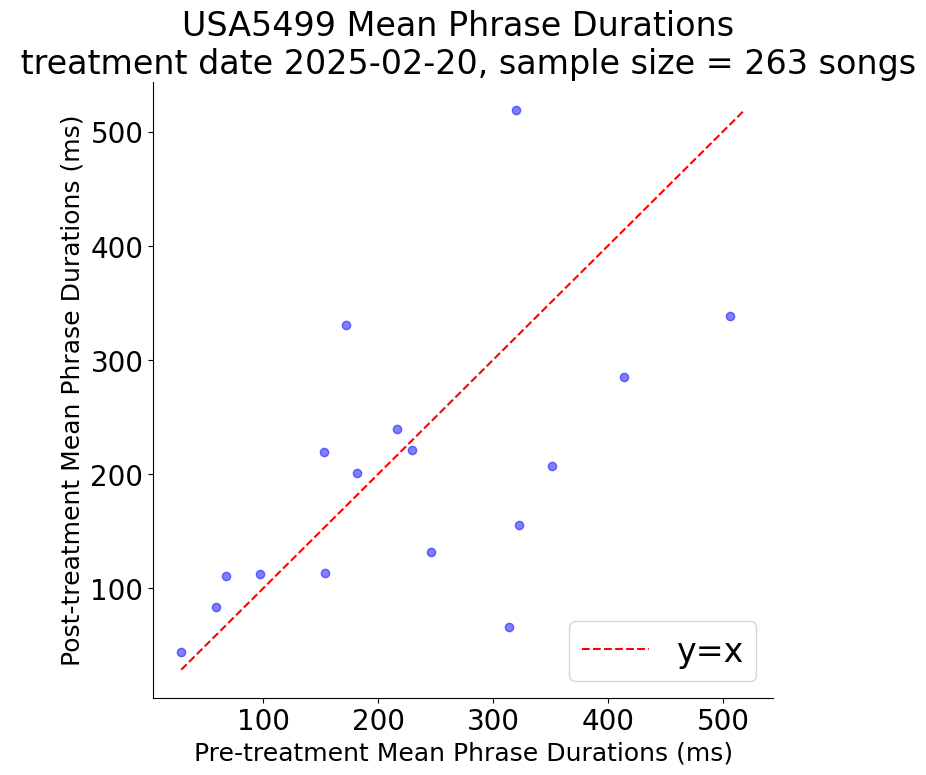

In [10]:
import matplotlib.pyplot as plt

# Extract mean values for each syllable from the statistics DataFrames
mean_pre_treatment = df_stats_pre_treatment['Mean']
mean_post_treatment = df_stats_post_treatment['Mean']

# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 8))  # Smaller figure size
ax.scatter(mean_pre_treatment, mean_post_treatment, color='b', alpha=0.5)

# Adding labels and title with increased font size and including animal_id
ax.set_xlabel('Pre-treatment Mean Phrase Durations (ms)', fontsize=18)
ax.set_ylabel('Post-treatment Mean Phrase Durations (ms)', fontsize=18)
ax.set_title(f'{animal_id} Mean Phrase Durations \n treatment date {treatment_date}, sample size = {song_sample_size} songs', fontsize=24)

# Adding a reference line to indicate no change
ax.plot([min(mean_pre_treatment.min(), mean_post_treatment.min()), max(mean_pre_treatment.max(), mean_post_treatment.max())],
        [min(mean_pre_treatment.min(), mean_post_treatment.min()), max(mean_pre_treatment.max(), mean_post_treatment.max())],
        'r--', label='y=x')

ax.legend(fontsize=24, loc = 'lower right')
ax.tick_params(axis='both', which='major', labelsize=20)

# Remove gridlines
ax.grid(False)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.show()


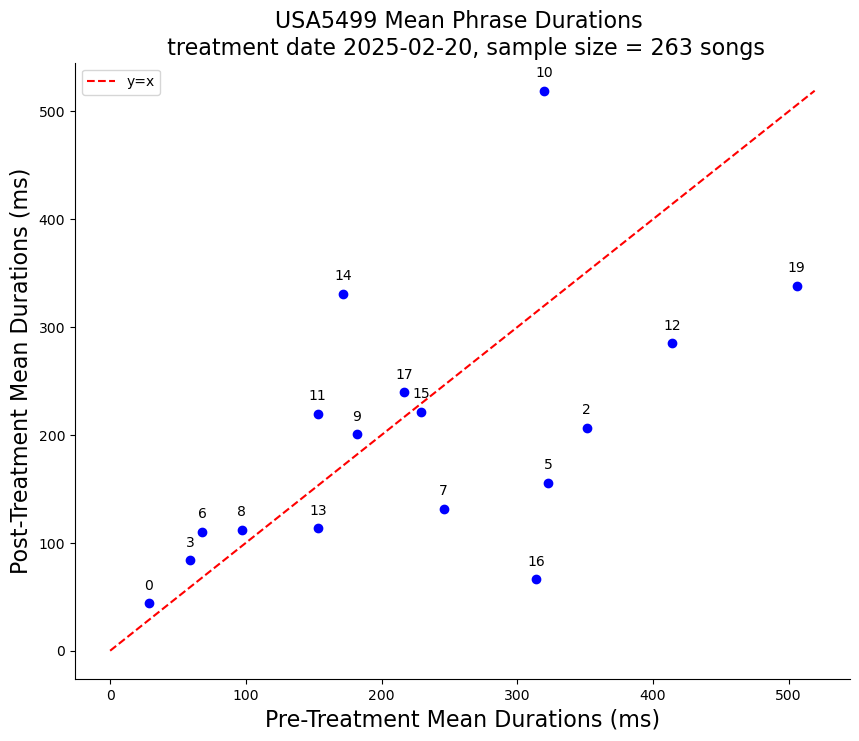

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df_stats_pre_treatment = pd.DataFrame(df_stats_pre_treatment)
df_stats_post_treatment = pd.DataFrame(df_stats_post_treatment)

# Extract mean values for plotting
mean_pre_treatment = df_stats_pre_treatment['Mean']
mean_post_treatment = df_stats_post_treatment['Mean']

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(mean_pre_treatment, mean_post_treatment, color='blue')

# Adding a red dashed line for y=x
max_value = max(max(mean_pre_treatment), max(mean_post_treatment))
plt.plot([0, max_value], [0, max_value], 'r--', label='y=x')

# Annotating each point with its syllable label (0, 1, ..., n-1)
for i, (x, y) in enumerate(zip(mean_pre_treatment, mean_post_treatment)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Adding plot labels and title
plt.xlabel('Pre-Treatment Mean Durations (ms)', fontsize = 16)
plt.ylabel('Post-Treatment Mean Durations (ms)', fontsize = 16)
plt.title(f'{animal_id} Mean Phrase Durations \n treatment date {treatment_date}, sample size = {song_sample_size} songs', fontsize=16)
# Remove spines & show legend
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.show()


In [12]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming df_stats_pre_treatment and df_stats_post_treatment are already defined DataFrames

# # Extract values for plotting
# mean_pre_treatment = df_stats_pre_treatment['Mean']
# mean_post_treatment = df_stats_post_treatment['Mean']
# median_pre_treatment = df_stats_pre_treatment['Median']
# median_post_treatment = df_stats_post_treatment['Median']
# variance_pre_treatment = df_stats_pre_treatment['Variance']
# variance_post_treatment = df_stats_post_treatment['Variance']

# # Create a figure with subplots
# fig, axs = plt.subplots(1, 3, figsize=(27, 8))  # 1 row, 3 columns

# # Define a function to plot data and annotations
# def plot_data(ax, x_data, y_data, title, x_label, y_label, color):
#     ax.scatter(x_data, y_data, color=color)
#     ax.plot([0, max(max(x_data), max(y_data))], [0, max(max(x_data), max(y_data))], 'r--', label='y=x')
#     ax.set_xlabel(x_label, fontsize=16)
#     ax.set_ylabel(y_label, fontsize=16)
#     ax.set_title(title, fontsize=16)
#     ax.legend()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     # Adding annotations for each point
#     for i, (x, y) in enumerate(zip(x_data, y_data)):
#         ax.annotate(f'S{i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# # Plotting Means
# plot_data(axs[0], mean_pre_treatment, mean_post_treatment, 'Mean Phrase Durations', 'Pre-Treatment (ms)', 'Post-Treatment (ms)', 'blue')

# # Plotting Medians
# plot_data(axs[1], median_pre_treatment, median_post_treatment, 'Median Phrase Durations', 'Pre-Treatment (ms)', 'Post-Treatment (ms)', 'green')

# # Plotting Variances
# plot_data(axs[2], variance_pre_treatment, variance_post_treatment, 'Variance of Phrase Durations', 'Pre-Treatment (ms²)', 'Post-Treatment (ms²)', 'black')

# # Set the overall title for the figure
# fig.suptitle(f'{animal_id} Phrase Durations\nTreatment Date: {treatment_date}, Sample Size: {song_sample_size} songs', fontsize=18, fontweight='bold')

# # Adjust subplot layout
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make space for the suptitle

# # Display the plot
# plt.show()


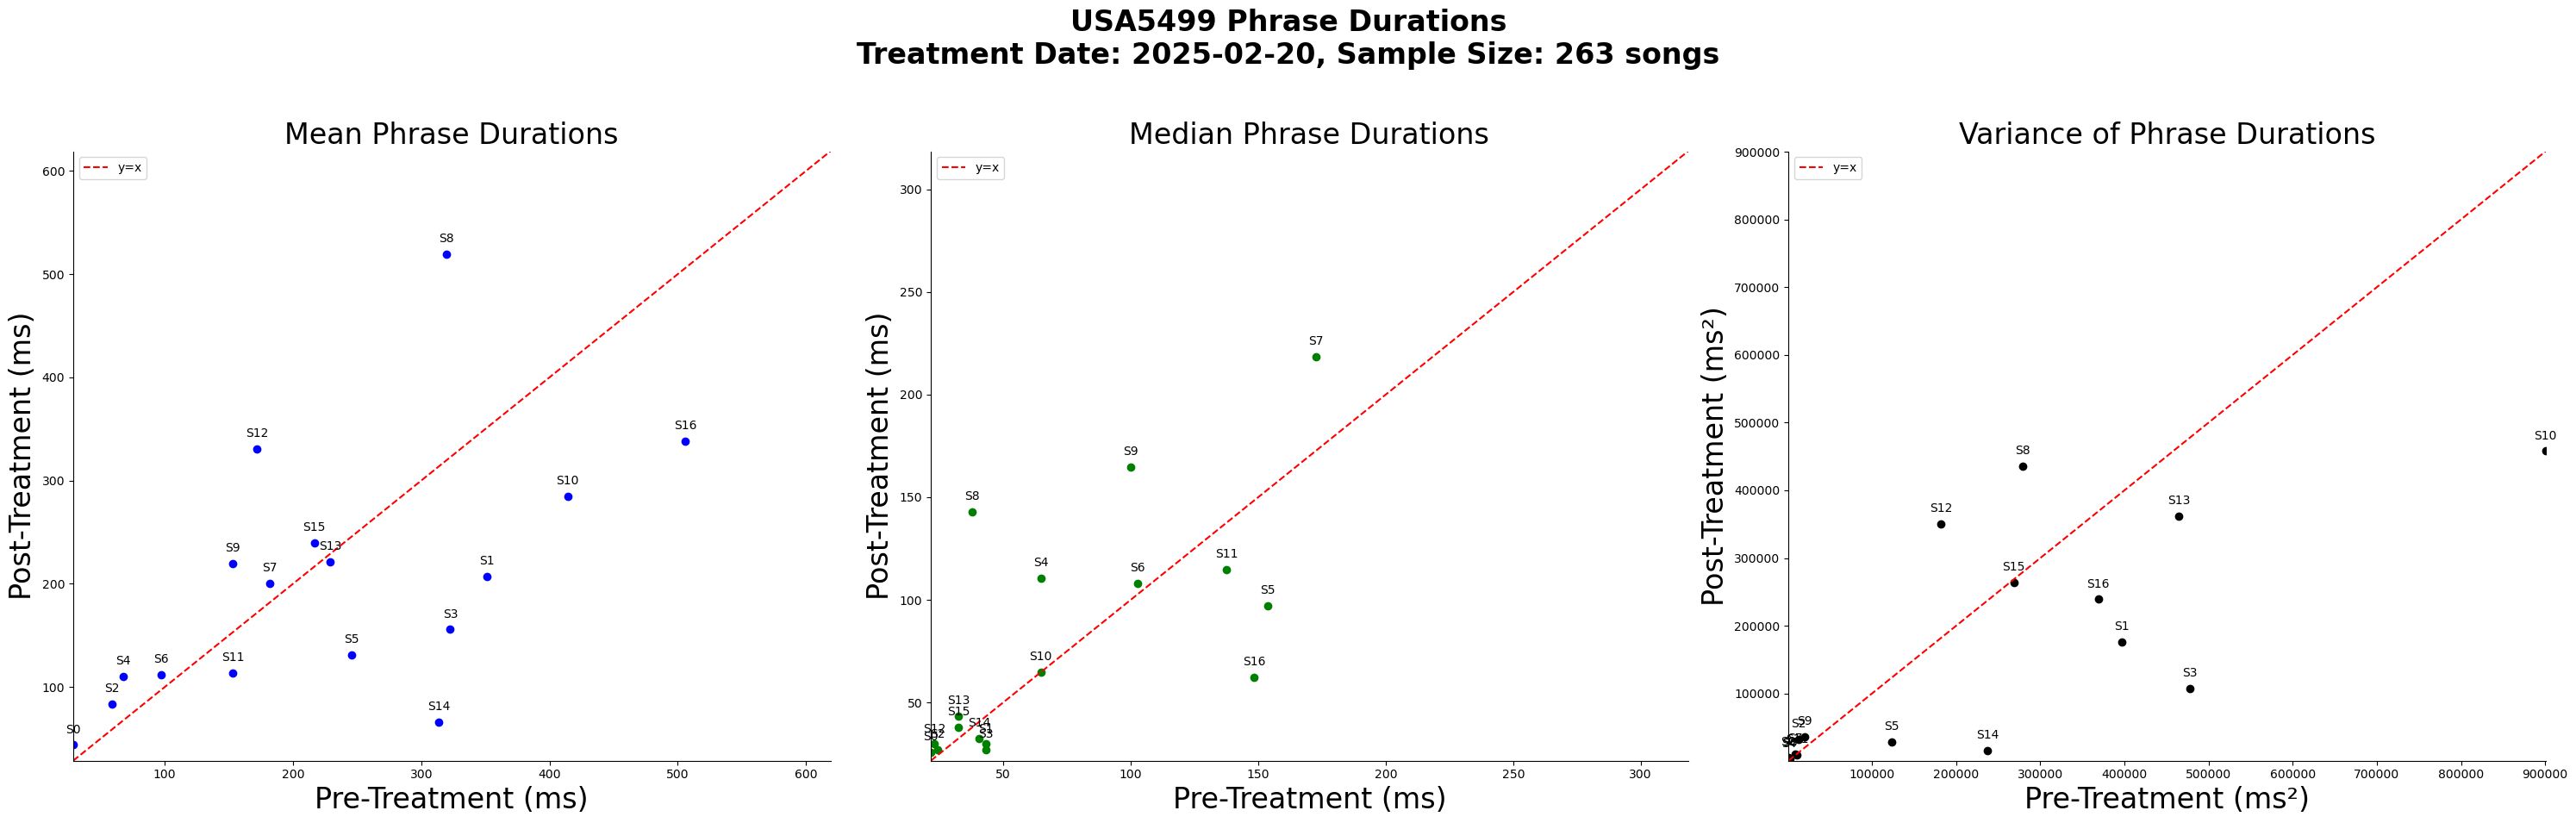

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_stats_pre_treatment and df_stats_post_treatment are already defined DataFrames

# Extract values for plotting
mean_pre_treatment = df_stats_pre_treatment['Mean']
mean_post_treatment = df_stats_post_treatment['Mean']
median_pre_treatment = df_stats_pre_treatment['Median']
median_post_treatment = df_stats_post_treatment['Median']
variance_pre_treatment = df_stats_pre_treatment['Variance']
variance_post_treatment = df_stats_post_treatment['Variance']

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10))  # 1 row, 3 columns

# Define a function to plot data and annotations
import numpy as np

# Define a function to plot data and annotations, including NaN and Inf handling
def plot_data(ax, x_data, y_data, title, x_label, y_label, color):
    # Handle NaNs or Infs in the data
    mask = np.isfinite(x_data) & np.isfinite(y_data)
    x_data = x_data[mask]
    y_data = y_data[mask]

    ax.scatter(x_data, y_data, color=color)
    # Set limits based on the valid data
    if len(x_data) > 0 and len(y_data) > 0:  # Check if there's any data left after removing NaNs/Infs
        lims = [
            min(min(x_data), min(y_data)),  # minimum of data
            max(max(x_data+100), max(y_data+100))   # maximum of data
        ]
        ax.plot(lims, lims, 'r--', label='y=x')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
    else:
        ax.plot([], [], 'r--', label='y=x')  # Plot an empty line with the label

    ax.set_xlabel(x_label, fontsize=24)
    ax.set_ylabel(y_label, fontsize=24)
    ax.set_title(title, fontsize=24)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Adding annotations for each point
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(f'S{i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Usage of the function remains the same, ensuring data passed into it is cleaned


# Plotting Means
plot_data(axs[0], mean_pre_treatment, mean_post_treatment, 'Mean Phrase Durations', 'Pre-Treatment (ms)', 'Post-Treatment (ms)', 'blue')

# Plotting Medians
plot_data(axs[1], median_pre_treatment, median_post_treatment, 'Median Phrase Durations', 'Pre-Treatment (ms)', 'Post-Treatment (ms)', 'green')
# Plotting Variances
plot_data(axs[2], variance_pre_treatment, variance_post_treatment, 'Variance of Phrase Durations', 'Pre-Treatment (ms²)', 'Post-Treatment (ms²)', 'black')

# Set the overall title for the figure
fig.suptitle(f'{animal_id} Phrase Durations\nTreatment Date: {treatment_date}, Sample Size: {song_sample_size} songs', fontsize=24, fontweight='bold')

# Adjust subplot layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make space for the suptitle

# Display the plot
plt.show()


<!-- # Another approach: get it to save as a .csv file, then later I'll combine them and graph them all together. -->

In [14]:
# Combining the data into a new DataFrame
combined_data = pd.DataFrame({
    'Mean_Pre_Treatment': mean_pre_treatment,
    'Mean_Post_Treatment': mean_post_treatment,
    'Median_Pre_Treatment': median_pre_treatment,
    'Median_Post_Treatment': median_post_treatment,
    'Variance_Pre_Treatment': variance_pre_treatment,
    'Variance_Post_Treatment': variance_post_treatment
})

# Adding the animal_id as the first column of the DataFrame
combined_data.insert(0, 'Animal_ID', animal_id)

# Extract the directory from the provided JSON file path
directory = os.path.dirname(json_file_path)

# Save to CSV in the same directory as the JSON file
combined_data.to_csv(os.path.join(directory, f'{animal_id}_treatment_comparison.csv'), index=False)


<!-- # Working on code that repeats for ALL the files in a given folder -->

In [15]:
import os
from collections import defaultdict

def find_matching_json_files(directory):
    files_by_animal = defaultdict(list)
    # Walk through the directory and subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                # Extract the animal ID by splitting the filename at the first underscore
                animal_id = file.split('_', 1)[0]
                files_by_animal[animal_id].append(os.path.join(root, file))

    # Filter out entries with less than 2 files
    matching_files = {animal_id: paths for animal_id, paths in files_by_animal.items() if len(paths) == 2}
    return matching_files

# Example usage:
folder_path = '/Users/mirandahulsey-vincent/Desktop'
matching_files = find_matching_json_files(folder_path)
print("Matching JSON files by animal ID:")
for animal_id, files in matching_files.items():
    print(f"{animal_id}: {files}")


Matching JSON files by animal ID:
image.png.json: ['/Users/mirandahulsey-vincent/Desktop/Misc/GooglePhoto/Takeout 2/Google Photos/Photos from 2020/image.png.json', '/Users/mirandahulsey-vincent/Desktop/Misc/GooglePhoto/Google Photos/Photos from 2017/image.png.json']
joined: ['/Users/mirandahulsey-vincent/Desktop/Misc/GooglePhoto/Takeout 2/Google Photos/Photos from 2020/joined_video_71e38559acad43cc98e3e7887ffda886..json', '/Users/mirandahulsey-vincent/Desktop/Misc/GooglePhoto/Google Photos/Photos from 2019/joined_video_4b6ce360003744ed989ea0584307b50c..json']
20170717: ['/Users/mirandahulsey-vincent/Desktop/Misc/GooglePhoto/Google Photos/Photos from 2017/20170717_094120.jpg.json', '/Users/mirandahulsey-vincent/Desktop/Misc/GooglePhoto/Google Photos/Photos from 2017/20170717_105410.jpg.json']
USA5288: ['/Users/mirandahulsey-vincent/Desktop/Area X lesions/song_databases_and_jsons/USA5288_creation_data.json', '/Users/mirandahulsey-vincent/Desktop/UniversityOfOregon/202401 2nd year Winter/

In [16]:
import os
from collections import defaultdict

def find_matching_json_files(directory):
    files_by_animal = defaultdict(list)
    # Walk through the directory and subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                # Extract the animal ID by splitting the filename at the first underscore
                animal_id = file.split('_', 1)[0]
                files_by_animal[animal_id].append(os.path.join(root, file))

    # Organize files by their specific roles
    organized_files = {}
    for animal_id, file_paths in files_by_animal.items():
        decoded_file = None
        creation_file = None
        for file_path in file_paths:
            if 'decoded_database' in file_path:
                decoded_file = file_path
            elif 'creation_data' in file_path:
                creation_file = file_path
        if decoded_file and creation_file:
            organized_files[animal_id] = {'decoded_database': decoded_file, 'creation_data': creation_file}

    return organized_files

# Example usage:
folder_path = '/Users/mirandahulsey-vincent/Desktop'
matching_files = find_matching_json_files(folder_path)
print("Organized JSON files by animal ID:")
for animal_id, files in matching_files.items():
    print(f"{animal_id}: Decoded: {files['decoded_database']}, Creation: {files['creation_data']}")


Organized JSON files by animal ID:
